In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import display
import skimage

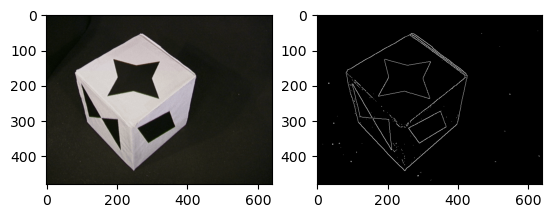

In [17]:
# 7.1
im = cv2.imread('data/week06_data/Box3.bmp')[:,:,::-1]
# im = im.astype(float)/255
edges = cv2.Canny(im, 110, 110)
fig, ax = plt.subplots(1,2)
ax[0].imshow(im, cmap='gray');
ax[1].imshow(edges, cmap='gray');